In [137]:
%matplotlib inline
from osgeo import gdal
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from mintpy.utils import readfile
from mintpy import workflow, view, tsview, plot_network, plot_transection, plot_coherence_matrix, load_data

In [34]:
cd ..

/home/fw/data/cosicorr


In [35]:
# create separate vrt files for each band
files = glob.glob('*.dat')
files.sort()
for fname in files:
    for b, dataset in enumerate(['EWOffset','NSOffset','offsetSNR']):
        fname_out = f'{os.path.splitext(fname)[0]}_{dataset}.tif'
        ds = gdal.Open(fname)
        ds = gdal.Translate(fname_out, ds, bandList = [b+1])
        ds = None

# write mintpy file
files = glob.glob('*EWOffset.tif')+glob.glob('*NSOffset.tif')+glob.glob('*offsetSNR.tif')
files.sort()
lines = [f'{f} {f[9:17]} {f[25:33]}\n' for f in files]
with open('metadata.txt', 'w') as f:
    f.writelines(lines)

In [36]:
cd mintpy

/home/fw/data/cosicorr/mintpy


In [1]:
!smallbaselineApp.py -g

--------------------------------------------------
Go to work directory: /home/fw/data/cosicorr/mintpy
copy default template file /home/fw/tools/MintPy/mintpy/defaults/smallbaselineApp.cfg to work directory
copy smallbaselineApp.cfg to inputs   directory for backup.
copy smallbaselineApp.cfg to pic      directory for backup.
read default template file: /home/fw/data/cosicorr/mintpy/smallbaselineApp.cfg
Go back to directory: /home/fw/data/cosicorr/mintpy

################################################
   Normal end of smallbaselineApp processing!
################################################
Time used: 00 mins 0.0 secs



In [166]:
!load_data.py -t cosicorr.cfg

processor : cosicorr
SAR platform/sensor : unknown from project name "None"
--------------------------------------------------
prepare metadata files for cosicorr products
prep_cosicorr.py ../*NSOffset.tif --metadata ../metadata.txt
prep_cosicorr.py ../*EWOffset.tif --metadata ../metadata.txt
prep_cosicorr.py ../*offsetSNR.tif --metadata ../metadata.txt
--------------------------------------------------
searching interferometric pairs info
input data files:
rangeOffset     : ../*EWOffset.tif
azimuthOffset   : ../*NSOffset.tif
offsetSNR       : ../*offsetSNR.tif
number of rangeOffset     : 15
number of azimuthOffset   : 15
number of offsetSNR       : 15
Un-recognized InSAR processor: cosicorr
--------------------------------------------------
searching geometry files info
input data files:
--------------------------------------------------
updateMode : False
compression: None
x/ystep: 1/1
--------------------------------------------------
create HDF5 file /home/fw/data/cosicorr/mintpy/i

In [167]:
!temporal_average.py inputs/ifgramStack.h5 -d offsetSNR -o avgSNR.h5

output file: avgSNR.h5
calculate the temporal average of offsetSNR in file inputs/ifgramStack.h5 ...
[==================================================] lines 501/501    0s /     0s
delete exsited file: avgSNR.h5
create HDF5 file: avgSNR.h5 with w mode
create dataset /offsetSNR of float32    in size of (501, 501)           with compression=None
finished writing to avgSNR.h5
time used: 00 mins 0.1 secs



In [168]:
!generate_mask.py avgSNR.h5 -m 0.9 -o maskSNR.h5

input offsetSNR file: avgSNR.h5
read avgSNR.h5
create initial mask with the same size as the input file and all = 1
all pixels with nan value = 0
exclude pixels with value < 0.9
delete exsited file: maskSNR.h5
create HDF5 file: maskSNR.h5 with w mode
create dataset /mask of bool       in size of (501, 501)           with compression=None
finished writing to maskSNR.h5
time used: 00 mins 0.0 secs.


In [169]:
!ifgram_inversion.py inputs/ifgramStack.h5 -i rangeOffset -w no --md offsetSNR --mt 0.9

skip checking reference pixel info - This is for offset and testing ONLY.
-------------------------------------------------------------------------------
least-squares solution with L2 min-norm on: deformation velocity
minimum redundancy: 1.0
weight function: no
mask out pixels with: offsetSNR < 0.9
-------------------------------------------------------------------------------
number of interferograms: 15
number of acquisitions  : 6
number of lines   : 501
number of columns : 501
--------------------------------------------------
create HDF5 file: timeseriesRg.h5 with w mode
create dataset  : date       of |S8                       in size of (6,)                 with compression = None
create dataset  : bperp      of <class 'numpy.float32'>   in size of (6,)                 with compression = None
create dataset  : timeseries of <class 'numpy.float32'>   in size of (6, 501, 501)        with compression = None
close  HDF5 file: timeseriesRg.h5
-----------------------------------------

In [170]:
!ifgram_inversion.py inputs/ifgramStack.h5 -i azimuthOffset -w no --md offsetSNR --mt 0.9

skip checking reference pixel info - This is for offset and testing ONLY.
-------------------------------------------------------------------------------
least-squares solution with L2 min-norm on: deformation velocity
minimum redundancy: 1.0
weight function: no
mask out pixels with: offsetSNR < 0.9
-------------------------------------------------------------------------------
number of interferograms: 15
number of acquisitions  : 6
number of lines   : 501
number of columns : 501
--------------------------------------------------
create HDF5 file: timeseriesAz.h5 with w mode
create dataset  : date       of |S8                       in size of (6,)                 with compression = None
create dataset  : bperp      of <class 'numpy.float32'>   in size of (6,)                 with compression = None
create dataset  : timeseries of <class 'numpy.float32'>   in size of (6, 501, 501)        with compression = None
close  HDF5 file: timeseriesAz.h5
-----------------------------------------

In [174]:
!timeseries2velocity.py timeseriesAz.h5 --bootstrap -o velocityAz.h5

bootstrapping is turned ON.
open timeseries file: timeseriesAz.h5
--------------------------------------------------
dates from input file: 6
['20160206', '20161122', '20171122', '20190225', '20191122', '20210130']
--------------------------------------------------
using all dates to calculate the velocity
--------------------------------------------------
estimate deformation model with the following assumed time functions:
    polynomial : 1
    periodic   : []
    step       : []
    exp        : {}
    log        : {}
add/update the following configuration metadata:
['startDate', 'endDate', 'excludeDate', 'bootstrap', 'bootstrapCount']
--------------------------------------------------
create HDF5 file: velocityAz.h5 with w mode
create dataset  : velocity    of <class 'numpy.float32'>   in size of (501, 501)           with compression = None
create dataset  : velocityStd of <class 'numpy.float32'>   in size of (501, 501)           with compression = None
add /velocity    attribute:

In [175]:
#need to change line to 32760
!save_gdal.py velocityAz.h5 -o velocityAz.tif

read metadata from file: velocityAz.h5
read data     from file: velocityAz.h5
initiate GDAL driver: GeoTIFF
create raster band
raster row / column number: 501, 501
raster transform info: (388970.0, 40.0, 0, 5615070.0, 0, -40.0)
write data to raster band
set projectection as: EPSG 4326
finished writing to /home/fw/data/cosicorr/mintpy/velocityAz.tif


[ 0. nan]


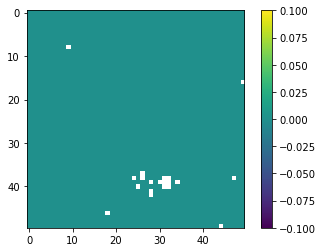

In [157]:
# !info.py inputs/ifgramStack.h5
# help(readfile.read)
s = slice(200,250), slice(200,250)
fname = '../cosicorr_20161122T221602_20190225T221559_EWOffset.tif'

# mintpy_data = readfile.read_gdal(fname)

mintpy_data, atr = readfile.read('inputs/ifgramStack.h5', datasetName='rangeOffset-20161122_20190225')

ds = gdal.Open(fname)
gdal_data = ds.GetRasterBand(1).ReadAsArray()
ds = None

matches = gdal_data - mintpy_data
print(np.unique(matches))
fig, ax = plt.subplots()
# im = ax.imshow(gdal_data[s])
# im = ax.imshow(mintpy_data[s])
im = ax.imshow(matches[s])
ax.figure.colorbar(im)

In [58]:
!ifgram_inversion.py inputs/ifgramStack.h5 -i rangeOffset -w no --md offsetSNR --mt 5
# ifgram_inversion.py inputs/ifgramStack.h5 -i azimuthOffset -w no -m waterMask.h5 --md offsetSNR --mt 5

skip checking reference pixel info - This is for offset and testing ONLY.
-------------------------------------------------------------------------------
least-squares solution with L2 min-norm on: deformation velocity
minimum redundancy: 1.0
weight function: no
mask out pixels with: offsetSNR < 5.0
-------------------------------------------------------------------------------
number of interferograms: 15
number of acquisitions  : 6
number of lines   : 501
number of columns : 501
--------------------------------------------------
create HDF5 file: timeseriesRg.h5 with w mode
create dataset  : date       of |S8                       in size of (6,)                 with compression = None
create dataset  : bperp      of <class 'numpy.float32'>   in size of (6,)                 with compression = None
create dataset  : timeseries of <class 'numpy.float32'>   in size of (6, 501, 501)        with compression = None
close  HDF5 file: timeseriesRg.h5
-----------------------------------------